Step 1: Install Necessary Libraries

In [1]:
!pip install yfinance numpy pandas matplotlib scikit-learn tensorflow


Step 2: Download Forex Data

In [2]:
import yfinance as yf

# Download EUR/USD forex data for the last two years
data = yf.download('EURUSD=X', start='2022-01-01', end='2023-01-01', interval='1d')

# Check the first few rows of the data
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X,EURUSD=X
Date,,,,,
2022-01-03,1.137346,1.137592,1.128541,1.137385,0
2022-01-04,1.130224,1.132300,1.127345,1.130199,0
2022-01-05,1.128363,1.134559,1.127764,1.128541,0
2022-01-06,1.131350,1.133067,1.128554,1.131222,0
2022-01-07,1.129688,1.135976,1.129050,1.129586,0


Step 3: Data Preprocessing

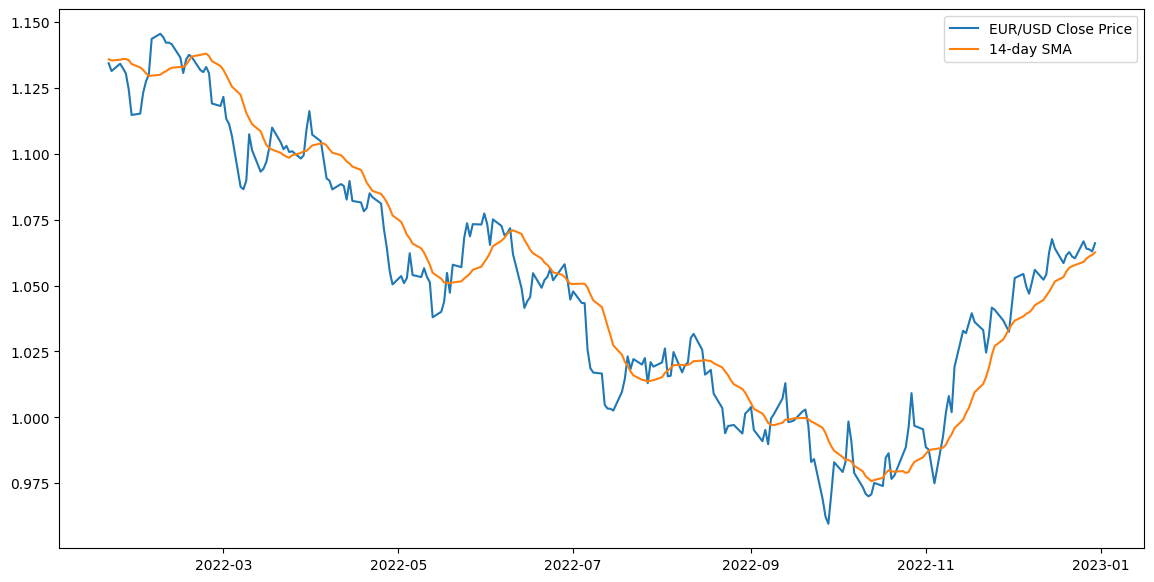

In [3]:
import pandas as pd
import numpy as np

# Handle missing values
data = data.dropna()

# Create technical indicators
data['SMA'] = data['Close'].rolling(window=14).mean()  # Simple Moving Average

# Calculate RSI
delta = data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Remove any rows with missing values after creating indicators
data = data.dropna()

# Plot Close Price and SMA
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='EUR/USD Close Price')
plt.plot(data['SMA'], label='14-day SMA')
plt.legend()
plt.show()


Step 4: Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close', 'SMA', 'RSI']].values)

# Create sequences for LSTM input (X, y)
def create_sequences(data, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])  # Features from previous 'sequence_length' time steps
        y.append(data[i, 0])  # Predict Close price (we'll change this for buy/sell later)
    return np.array(X), np.array(y)

# Prepare sequences
X, y = create_sequences(scaled_data)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


Step 5: Build the LSTM Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Predicting a continuous value

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.1414
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0208
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0085
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0125
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0064
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0072
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0070
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0059
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0053
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0047


Step 6: Evaluate the Model

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


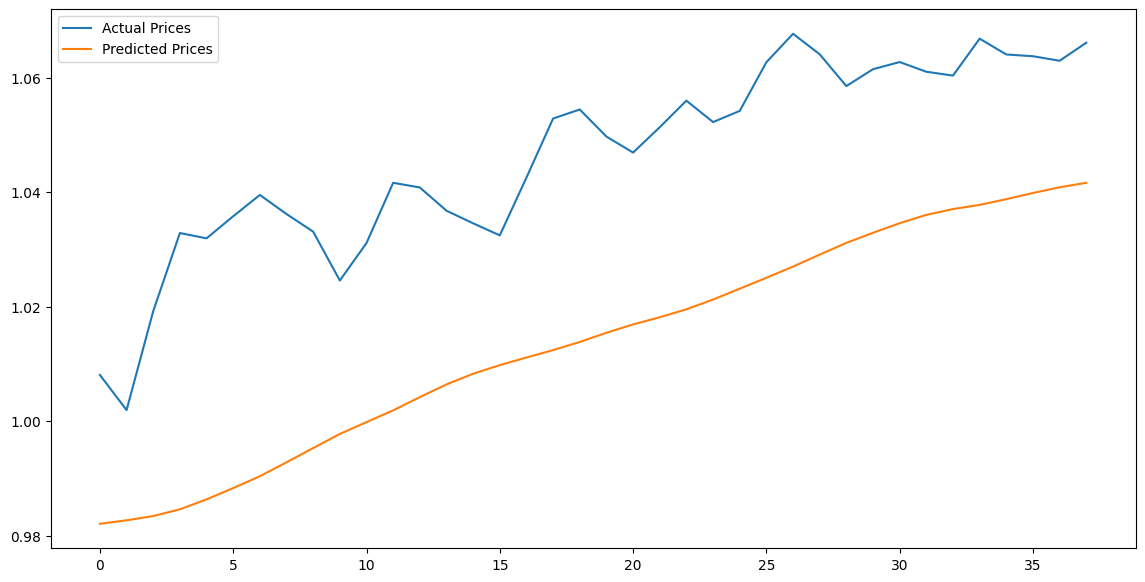

In [6]:
# Predict the prices
y_pred = model.predict(X_test)

# Inverse scaling to get the actual prices
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1)), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.legend()
plt.show()


Step 7: Generating Trading Signals

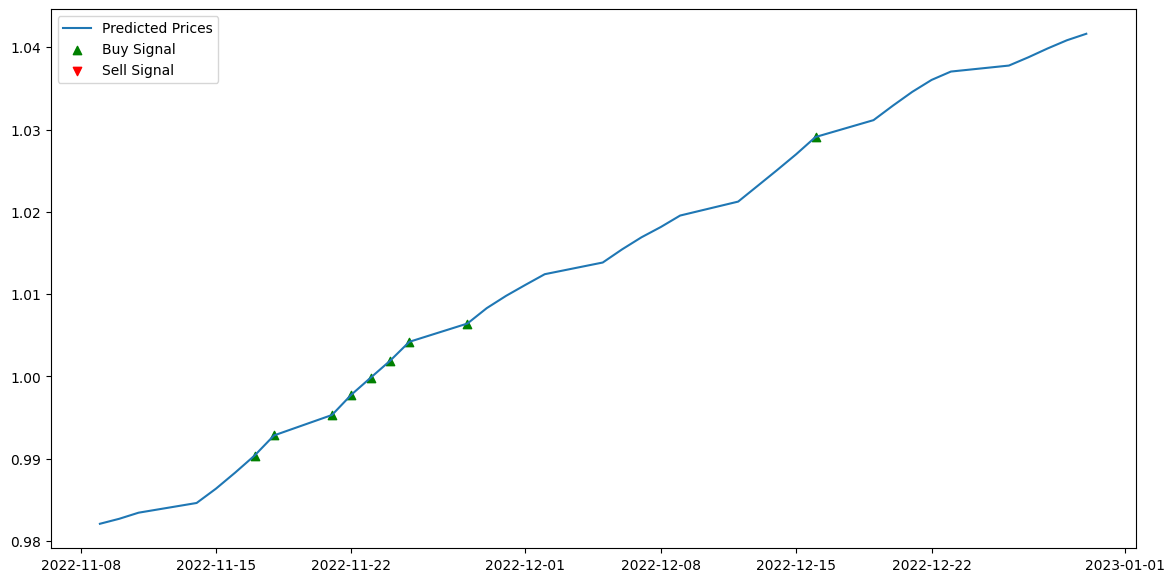

In [7]:
# Define a threshold percentage for price movement (e.g., 0.2%)
threshold = 0.002  # 0.2% change

# Generate buy/sell signals based on the price change exceeding the threshold
signals = []
for i in range(1, len(y_pred_rescaled)):
    if y_pred_rescaled[i] > y_pred_rescaled[i-1] * (1 + threshold):
        signals.append("buy")
    elif y_pred_rescaled[i] < y_pred_rescaled[i-1] * (1 - threshold):
        signals.append("sell")
    else:
        signals.append("hold")

# Ensure the signals length matches the length of y_pred_rescaled
signals = ['hold'] + signals  # Add 'hold' for the first prediction

# Plotting the predicted prices with the buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(signals):], y_pred_rescaled, label='Predicted Prices')

# Plot Buy signals (green upward triangles)
plt.scatter(data.index[-len(signals):][np.array(signals) == 'buy'],
            y_pred_rescaled[np.array(signals) == 'buy'],
            marker='^', color='g', label='Buy Signal')

# Plot Sell signals (red downward triangles)
plt.scatter(data.index[-len(signals):][np.array(signals) == 'sell'],
            y_pred_rescaled[np.array(signals) == 'sell'],
            marker='v', color='r', label='Sell Signal')

plt.legend()
plt.show()


Step 8: Evaluating the Strategy Performance

In [8]:
# Create a DataFrame to simulate trading actions
trade_signals = pd.DataFrame({
    'Date': data.index[-len(signals):],
    'Predicted Prices': y_pred_rescaled,
    'Signal': signals
})

# Assuming you start with $1,000
initial_balance = 1000
balance = initial_balance
holdings = 0  # initially no holdings
trades = []

# Execute the strategy
for i in range(1, len(trade_signals)):
    if trade_signals['Signal'][i] == "buy" and holdings == 0:
        # Buy the asset
        holdings = balance / trade_signals['Predicted Prices'][i]
        balance = 0
        trades.append(('buy', trade_signals['Date'][i], trade_signals['Predicted Prices'][i]))
    elif trade_signals['Signal'][i] == "sell" and holdings > 0:
        # Sell the asset
        balance = holdings * trade_signals['Predicted Prices'][i]
        holdings = 0
        trades.append(('sell', trade_signals['Date'][i], trade_signals['Predicted Prices'][i]))

# Calculate final value of portfolio
final_value = balance if holdings == 0 else holdings * trade_signals['Predicted Prices'].iloc[-1]
print(f"Final Portfolio Value: ${final_value:.2f}")


Final Portfolio Value: $1051.72


Step 9: Evaluate Performance Metrics

In [9]:
import numpy as np

# Calculate daily returns (simple returns)
returns = np.diff(y_pred_rescaled) / y_pred_rescaled[:-1]

# Calculate Sharpe ratio
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized Sharpe Ratio
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: 48.49


Step 10: Save the model

In [10]:
# Save the trained model
model.save("forex_signal_model.h5")


Refined Model Code

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Build the refined LSTM model
model = Sequential()

# First LSTM layer with dropout for regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Second LSTM layer with dropout
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Dense layer for output
model.add(Dense(units=1))  # Predicting the closing price

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.1095 - val_loss: 0.0026
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0174 - val_loss: 0.0513
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0162 - val_loss: 0.0386
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0057 - val_loss: 0.0164
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0097 - val_loss: 0.0352
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0062 - val_loss: 0.0377
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0066 - val_loss: 0.0250
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0058 - val_loss: 0.0261
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0059 - val_loss: 0.0352
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0063 - val_loss: 0.0303
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0055 - val_loss: 0.0243


Evaluate the Model

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


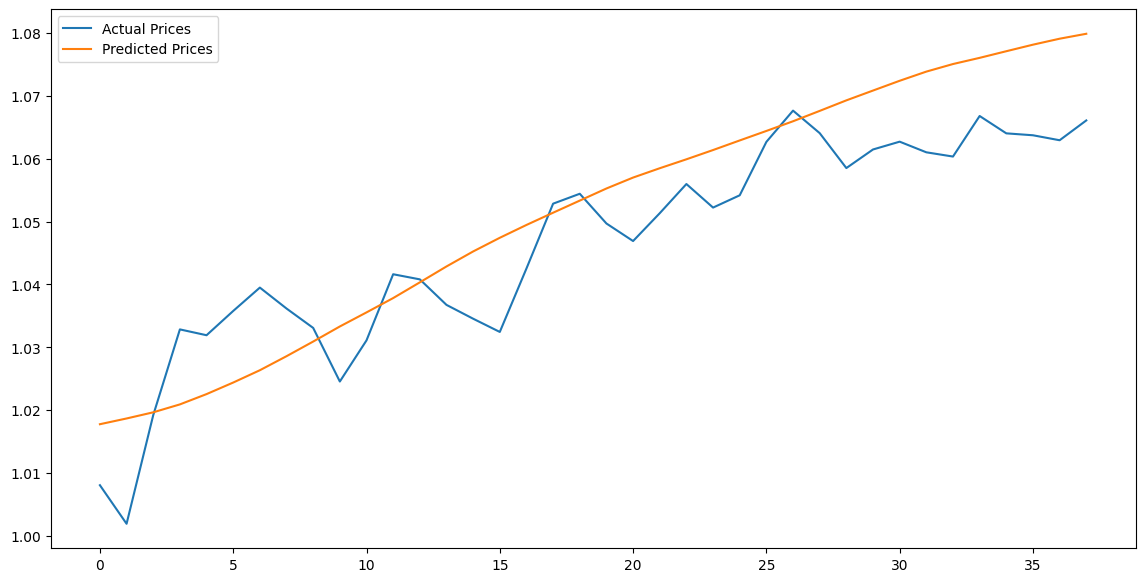

In [12]:
# Evaluate the model on the test data
y_pred = model.predict(X_test)

# Inverse scaling to get the actual prices
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)), axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1)), np.zeros_like(y_test.reshape(-1, 1))), axis=1))[:, 0]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Actual Prices')
plt.plot(y_pred_rescaled, label='Predicted Prices')
plt.legend()
plt.show()


V2 Model

In [13]:
# Save the trained model
model.save("forex_signal_model_refined.h5")
